In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input,LSTM,Dense
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pickle

In [ ]:
#read dataset file

data_path = "/content/drive/MyDrive/fra-eng/fra.txt"

In [ ]:
num_samples = 10000
latent_dim = 256
epochs= 100
batch_size = 64

In [ ]:
#initialize all variables 
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path,'r',encoding='utf-8') as f:
    lines=f.read().split('\n')
for line in lines[: min(num_samples, len(lines)-1)]:
    #split input and target by '\t'=tab
    input_text,target_text,_ = line.split('\t')
    #add '\t' at start and '\n' at end of text.
    target_text='\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
      if char not in input_characters:
        input_characters.add(char)
    for char in target_text:
      if char not in target_characters:
        target_characters.add(char)

In [ ]:
len(input_texts)

10000

In [ ]:
input_characters

{' ',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '7',
 '8',
 '9',
 ':',
 '?',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'Y',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 'é'}

In [ ]:
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

In [ ]:
print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 93
Max sequence length for inputs: 15
Max sequence length for outputs: 59


In [ ]:
input_token_index = dict([(char,i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char,i) for i, char in enumerate(target_characters)])

In [ ]:
input_token_index #target_token_index

{' ': 0,
 '!': 1,
 '"': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 ',': 7,
 '-': 8,
 '.': 9,
 '0': 10,
 '1': 11,
 '2': 12,
 '3': 13,
 '5': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 ':': 18,
 '?': 19,
 'A': 20,
 'B': 21,
 'C': 22,
 'D': 23,
 'E': 24,
 'F': 25,
 'G': 26,
 'H': 27,
 'I': 28,
 'J': 29,
 'K': 30,
 'L': 31,
 'M': 32,
 'N': 33,
 'O': 34,
 'P': 35,
 'Q': 36,
 'R': 37,
 'S': 38,
 'T': 39,
 'U': 40,
 'V': 41,
 'W': 42,
 'Y': 43,
 'a': 44,
 'b': 45,
 'c': 46,
 'd': 47,
 'e': 48,
 'f': 49,
 'g': 50,
 'h': 51,
 'i': 52,
 'j': 53,
 'k': 54,
 'l': 55,
 'm': 56,
 'n': 57,
 'o': 58,
 'p': 59,
 'q': 60,
 'r': 61,
 's': 62,
 't': 63,
 'u': 64,
 'v': 65,
 'w': 66,
 'x': 67,
 'y': 68,
 'z': 69,
 'é': 70}

In [ ]:
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')


In [ ]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
  for t, char in enumerate(input_text):
    encoder_input_data[i, t, input_token_index[char]] = 1
  encoder_input_data[i, t + 1:, input_token_index[' ']] = 1
  for t, char in enumerate(target_text):
    decoder_input_data[i, t, target_token_index[char]] = 1
    if t > 0:
      decoder_target_data[i, t - 1, target_token_index[char]] = 1
  decoder_input_data[i, t + 1:, target_token_index[' ']] = 1
  decoder_target_data[i, t:, target_token_index[' ']] = 1

In [ ]:
encoder_input_data[0].shape

(15, 71)

In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [ ]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences= True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state= encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size= batch_size,
          epochs = epochs,
          validation_split=0.2)

Epoch 1/100
125/125 [==============================] - 10s 21ms/step - loss: 1.1259 - accuracy: 0.7370 - val_loss: 1.0271 - val_accuracy: 0.7165
Epoch 2/100
125/125 [==============================] - 2s 12ms/step - loss: 0.8047 - accuracy: 0.7825 - val_loss: 0.8260 - val_accuracy: 0.7698
Epoch 3/100
125/125 [==============================] - 2s 12ms/step - loss: 0.6404 - accuracy: 0.8183 - val_loss: 0.6850 - val_accuracy: 0.7971
Epoch 4/100
125/125 [==============================] - 2s 12ms/step - loss: 0.5860 - accuracy: 0.8313 - val_loss: 0.6322 - val_accuracy: 0.8165
Epoch 5/100
125/125 [==============================] - 2s 12ms/step - loss: 0.5239 - accuracy: 0.8470 - val_loss: 0.5867 - val_accuracy: 0.8272
Epoch 6/100
125/125 [==============================] - 2s 12ms/step - loss: 0.4890 - accuracy: 0.8564 - val_loss: 0.5654 - val_accuracy: 0.8332
Epoch 7/100
125/125 [==============================] - 2s 12ms/step - loss: 0.4616 - accuracy: 0.8635 - val_loss: 0.5365 - val_accuracy

In [ ]:
model.save("Language_translation_s2s")

In [ ]:
/content/drive/MyDrive/fra-eng

In [ ]:
model.save("/content/drive/MyDrive/fra-eng/Language_translation_s2s")

In [ ]:
#summary and model plot
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 71)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 93)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        335872      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

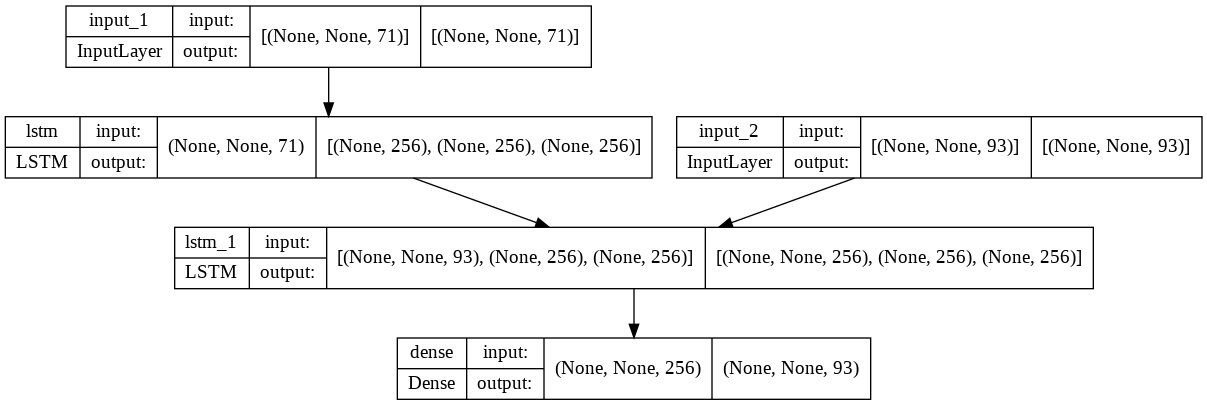

In [ ]:
plot_model(model, to_file='Model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

#Reverse-lookup token index to decode sequence back 
reverse_input_char_index = dict(
    (i,char) for char , i in inpu_token_index.items())
reverse_target_char_index = dict(
    (i,char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(4):
  input_seq = encoder_input_data[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[seq_index])
  print('Decoded sentence:', decoded_sentence)